In [34]:
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler


dat = yf.Ticker('MSFT')
history_df = dat.history()

In [35]:
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        target = data[i + seq_length]
        X.append(seq)
        y.append(target)
    return np.array(X), np.array(y)

In [36]:
closing_prices = history_df['Close'].values
SEQ_LENGTH = 3
X, y = create_sequences(closing_prices, SEQ_LENGTH)

In [37]:
# Ensure split is chronological
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)

# Create training, validation, and testing sets
X_train, y_train = X[:train_size], y[:train_size]
X_valid, y_valid = X[train_size: train_size + val_size], y[train_size: train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

In [38]:
# Handle scaling
scaler_X = MinMaxScaler()

X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
scaler_X.fit(X_train_reshaped)

,feature_range,"(0, ...)"
,copy,True
,clip,False


In [39]:
def scale_3d(X, scaler):
    shape = X.shape
    X_reshaped = X.reshape(-1, shape[-1])
    X_scaled = scaler.transform(X_reshaped)
    return X_scaled.reshape(shape)

In [40]:
# scale all X splits
X_train_scaled = scale_3d(X_train, scaler_X)
X_valid_scaled = scale_3d(X_valid, scaler_X)
X_test_scaled = scale_3d(X_test, scaler_X)

In [41]:
# scale y
scaler_y = MinMaxScaler()
y_train = y_train.reshape(-1, 1)
y_valid = y_valid.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

scaler_y.fit(y_train)

y_train_scaled = scaler_y.transform(y_train).flatten()
y_valid_scaled = scaler_y.transform(y_valid).flatten()
y_test_scaled = scaler_y.transform(y_test).flatten()

In [42]:
from torch.utils.data import Dataset
import torch

class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [43]:
train_ds = StockDataset(X_train_scaled, y_train_scaled)
valid_ds = StockDataset(X_valid_scaled, y_valid_scaled)
test_ds = StockDataset(X_test_scaled, y_test_scaled)

In [44]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=32, shuffle=False)
val_loader = DataLoader(valid_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

In [45]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x.unsqueeze(-1))  # Add channel dim: (batch, seq_len, 1)
        out = self.fc(out[:, -1, :])         # Use last timestep output
        return out.squeeze()                 # Remove unnecessary dimensions

In [46]:
model = LSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [47]:
EPOCHS = 20
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Training Loss: {total_loss / len(train_loader):.4f}")

Epoch 1, Training Loss: 0.3572
Epoch 2, Training Loss: 0.3454
Epoch 3, Training Loss: 0.3339
Epoch 4, Training Loss: 0.3226
Epoch 5, Training Loss: 0.3114
Epoch 6, Training Loss: 0.3003
Epoch 7, Training Loss: 0.2892
Epoch 8, Training Loss: 0.2782
Epoch 9, Training Loss: 0.2672
Epoch 10, Training Loss: 0.2561
Epoch 11, Training Loss: 0.2450
Epoch 12, Training Loss: 0.2339
Epoch 13, Training Loss: 0.2227
Epoch 14, Training Loss: 0.2115
Epoch 15, Training Loss: 0.2003
Epoch 16, Training Loss: 0.1890
Epoch 17, Training Loss: 0.1778
Epoch 18, Training Loss: 0.1668
Epoch 19, Training Loss: 0.1559
Epoch 20, Training Loss: 0.1454


In [48]:
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        output = model(X_batch)
        predictions.extend(output.cpu().numpy())
        actuals.extend(y_batch.numpy())

# Invert scaling
pred_prices = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
true_prices = scaler_y.inverse_transform(np.array(actuals).reshape(-1, 1)).flatten()

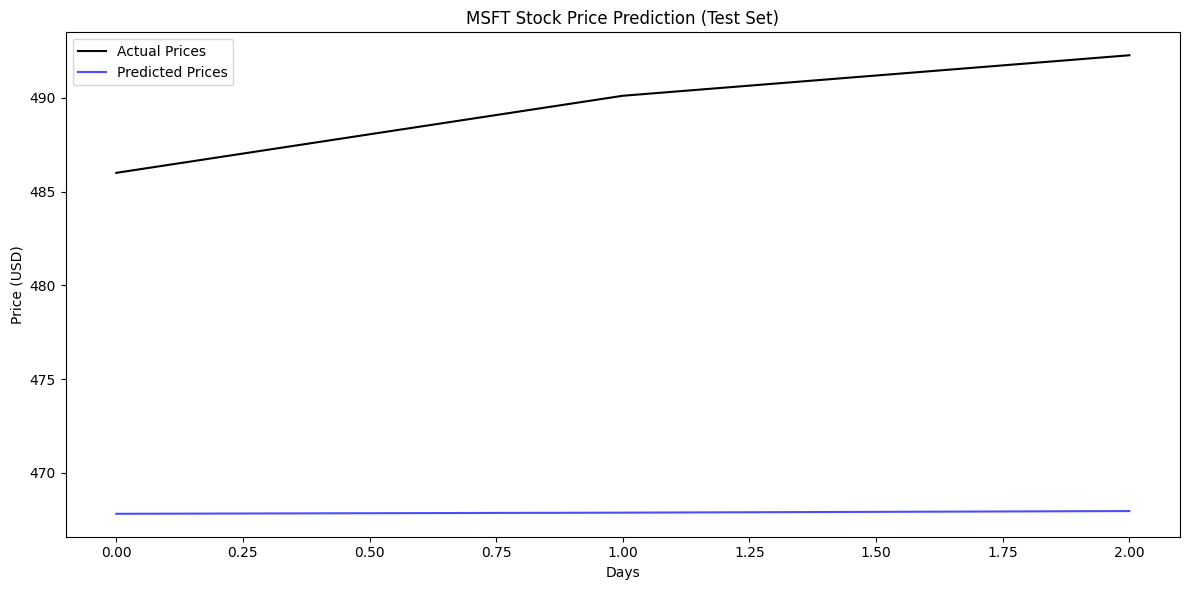

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(true_prices, label="Actual Prices", color='black')
plt.plot(pred_prices, label="Predicted Prices", color='blue', alpha=0.7)
plt.title("MSFT Stock Price Prediction (Test Set)")
plt.xlabel("Days")
plt.ylabel("Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()